In [1]:
import pandas as pd

df = pd.read_csv("dirty_cafe_sales.csv")
print(df.head(5))

  Transaction ID    Item Quantity Price Per Unit Total Spent  Payment Method  \
0    TXN_1961373  Coffee        2            2.0         4.0     Credit Card   
1    TXN_4977031    Cake        4            3.0        12.0            Cash   
2    TXN_4271903  Cookie        4            1.0       ERROR     Credit Card   
3    TXN_7034554   Salad        2            5.0        10.0         UNKNOWN   
4    TXN_3160411  Coffee        2            2.0         4.0  Digital Wallet   

   Location Transaction Date  
0  Takeaway       2023-09-08  
1  In-store       2023-05-16  
2  In-store       2023-07-19  
3   UNKNOWN       2023-04-27  
4  In-store       2023-06-11  


Removing Duplicates

In [3]:
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicates: 0


Removing/Replacing unknown values

In [31]:
import numpy as np
import pandas as pd

df.replace(['ERROR', 'UNKNOWN'], np.nan, inplace=True)

df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip().str.lower()

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

print(df.isnull().sum())

df['Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df = df.dropna(subset=['Transaction Date'])

Transaction ID         0
Item                 969
Quantity              38
Price Per Unit        38
Total Spent           40
Payment Method      2872
Location            3961
Transaction Date     460
Date                   0
dtype: int64


C:\Users\Abhay\AppData\Local\Temp\ipykernel_2764\1914926348.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Filling Quantity, Price per unit and Total Spent using the relationship between them

In [14]:
mask_qty_missing = df['Quantity'].isna() & df['Total Spent'].notna() & df['Price Per Unit'].notna()
df.loc[mask_qty_missing, 'Quantity'] = df.loc[mask_qty_missing, 'Total Spent'] / df.loc[mask_qty_missing, 'Price Per Unit']

mask_price_missing = df['Price Per Unit'].isna() & df['Total Spent'].notna() & df['Quantity'].notna()
df.loc[mask_price_missing, 'Price Per Unit'] = df.loc[mask_price_missing, 'Total Spent'] / df.loc[mask_price_missing, 'Quantity']

mask_total_missing = df['Total Spent'].isna() & df['Quantity'].notna() & df['Price Per Unit'].notna()
df.loc[mask_total_missing, 'Total Spent'] = df.loc[mask_total_missing, 'Quantity'] * df.loc[mask_total_missing, 'Price Per Unit']


Data Visualization:

Graph 1: 
Bar graph representing which item sells the most in a prticular location giving insights on the sales and how to improve upon the same

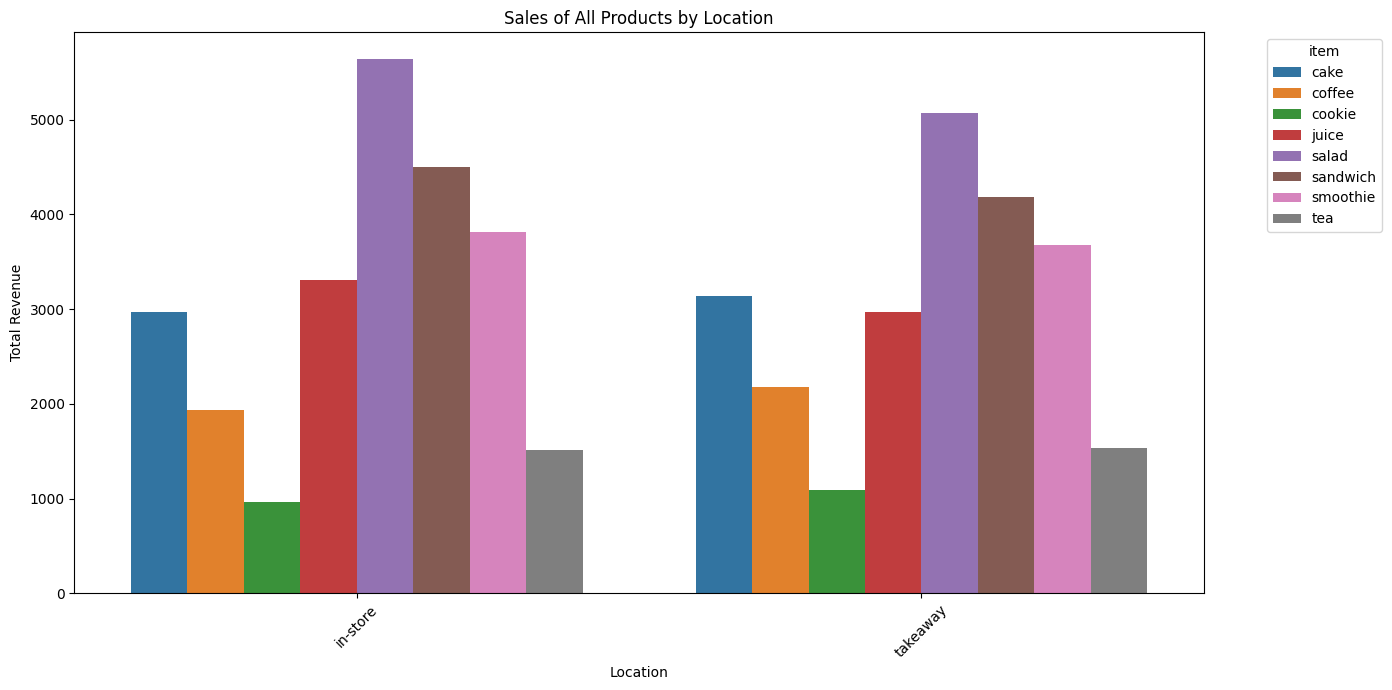

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

location_product_sales = df.groupby(['Location', 'Item'])['Total Spent'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=location_product_sales, x='Location', y='Total Spent', hue='Item')

plt.title('Sales of All Products by Location')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Graph 2:
Payment Method Usage by Location


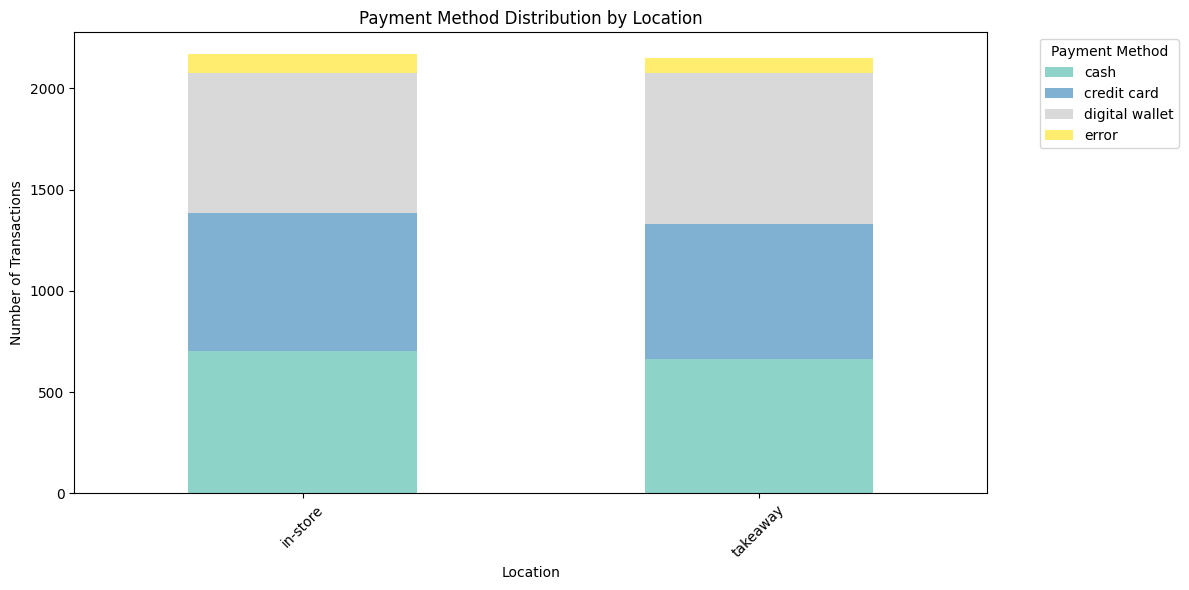

In [23]:
payment_usage = df.groupby(['Location', 'Payment Method']).size().unstack().fillna(0)

payment_usage.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set3')
plt.title('Payment Method Distribution by Location')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Graph 3:
Correlation Heatmap (Advanced Insight)

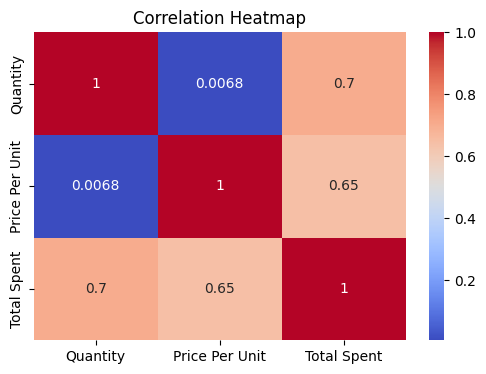

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(df[['Quantity', 'Price Per Unit', 'Total Spent']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Graph 4:
Top 5 locations with Highest Monthly Sales

In [35]:
df['YearMonth'] = df['Date'].dt.to_period('M')

monthly_location_sales = df.groupby(['Location', 'YearMonth'])['Total Spent'].sum().reset_index()

top_monthly_location = monthly_location_sales.loc[monthly_location_sales['Total Spent'].idxmax()]

print("Location with the highest total sales in a single month:")
print(top_monthly_location)


Location with the highest total sales in a single month:
Location       in-store
YearMonth       2023-06
Total Spent      2340.5
Name: 5, dtype: object


C:\Users\Abhay\AppData\Local\Temp\ipykernel_2764\200924389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearMonth'] = df['Date'].dt.to_period('M')


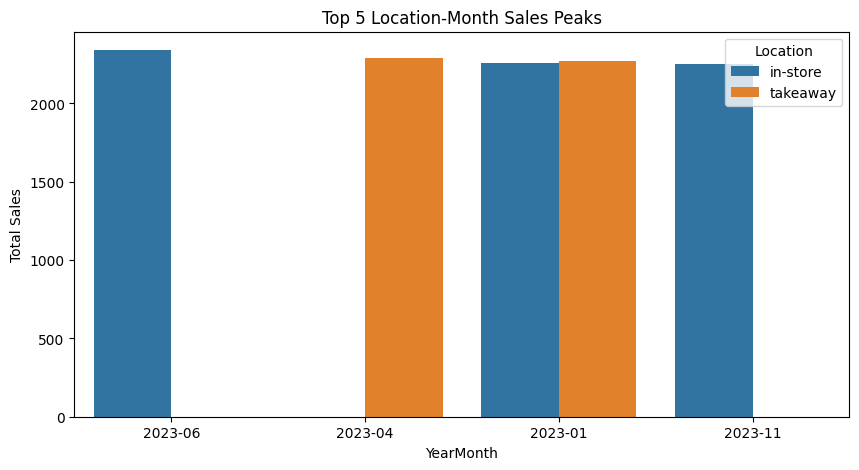

In [36]:
top_5 = monthly_location_sales.sort_values(by='Total Spent', ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(data=top_5, x='YearMonth', y='Total Spent', hue='Location')
plt.title('Top 5 Location-Month Sales Peaks')
plt.ylabel('Total Sales')
plt.show()
